In [58]:
import sys
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import balanced_accuracy_score, make_scorer
from imblearn.over_sampling import RandomOverSampler
from sklearn import model_selection
from sklearn.svm import SVC
from sklearn.cluster import SpectralClustering
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier
from xgboost import plot_tree


#Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

sys.path.insert(0, '/Users/gracewang/Documents/GitHub/elecfinal')
sys.path.insert(0, 'D:\Fall23 Coursework\ELEC478\Competition\elecfinal')
from ml_pipeline import train_n_predict, validation, clean_split
from Data.data_cleaner import cleaner

In [59]:
## Clean and split data
train_path = "../Data/train_data.csv"
feature_path = "../Data/feature_weights.csv"
morph_path = "../Data/imputed_morph_embed.csv"
clean_data = cleaner(train_path, feature_path, morph_path)

In [60]:
clean_data

,ID,axonal_coor_x,axonal_coor_y,axonal_coor_z,dendritic_coor_x,dendritic_coor_y,dendritic_coor_z,adp_dist,post_skeletal_distance_to_soma,pre_skeletal_distance_to_soma,...,AL_pre,V1_pre,RL_post,V1_post,AL_post,area1,area2,area3,minicol_dist,nuclei_adp_dist
0,42593,0.445791,-1.742979,2.174696,0.444810,-1.740997,2.176315,-1.515697,2.007164,0.931055,...,-0.545885,-0.813463,1.182234,-0.852369,-0.439881,-1.076967,1.166722,-0.202758,-0.262374,0.076496
1,42594,0.507204,0.365932,0.044530,0.507420,0.368718,0.052049,-1.225578,1.070301,0.268030,...,-0.545885,-0.813463,1.182234,-0.852369,-0.439881,-1.076967,1.166722,-0.202758,-0.262374,-0.306546
2,42595,0.460781,-1.807635,2.215744,0.449166,-1.817435,2.210853,0.632301,2.099967,0.905442,...,-0.545885,-0.813463,1.182234,-0.852369,-0.439881,-1.076967,1.166722,-0.202758,-0.262374,0.118612
3,42596,0.433668,-1.686017,2.114604,0.442015,-1.682527,2.140593,0.645635,1.931656,0.956222,...,-0.545885,-0.813463,1.182234,-0.852369,-0.439881,-1.076967,1.166722,-0.202758,-0.262374,0.035778
4,42597,0.451199,0.293911,0.745737,0.449891,0.328971,0.733044,1.334344,1.668055,-0.042977,...,-0.545885,-0.813463,1.182234,-0.852369,-0.439881,-1.076967,1.166722,-0.202758,-0.262374,-0.587712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185827,228420,0.709191,-0.639091,0.441756,0.717718,-0.655646,0.436799,0.452526,-0.282486,0.324338,...,-0.545885,-0.813463,1.182234,-0.852369,-0.439881,-1.076967,1.166722,-0.202758,-0.214541,-0.780397
185828,228421,0.543500,-1.794867,0.474081,0.537437,-1.818791,0.460571,0.687832,-0.042144,0.817518,...,-0.545885,-0.813463,1.182234,-0.852369,-0.439881,-1.076967,-0.857102,4.931999,-0.214541,0.047859
185829,228422,0.577400,-2.030573,-0.272713,0.566982,-2.048065,-0.249929,0.987837,0.182085,0.910021,...,-0.545885,-0.813463,1.182234,-0.852369,-0.439881,-1.076967,-0.857102,4.931999,-0.214541,0.385538
185830,228423,0.684728,-1.930889,-0.146313,0.698481,-1.913531,-0.140918,1.162151,-0.079219,0.792450,...,-0.545885,-0.813463,1.182234,-0.852369,-0.439881,-1.076967,-0.857102,4.931999,-0.214541,0.261090


In [61]:
import random

def splitter(data):
# perform stratified sampling of pre-synaptic neurons
    pre_nucleus_ids = pd.unique(data["pre_nucleus_id"])
    #print(len(pre_nucleus_ids))

    # Use 80% of the pre-nucleus ids
    #print(len(pre_nucleus_ids))
    train_nucleus_idx = random.sample(range(0, len(pre_nucleus_ids)), int(np.floor(0.8*len(pre_nucleus_ids))))
    train_nucleus_ids = pre_nucleus_ids[train_nucleus_idx]
    training = data[data["pre_nucleus_id"].isin(train_nucleus_ids)]
    X_train = training.drop(columns='connected')
    y_train = training['connected']
    pre_nucleus_ids = np.delete(pre_nucleus_ids, train_nucleus_idx)

    # # Use 20% for query set
    # #print(len(pre_nucleus_ids))
    # query_nucleus_idx = random.sample(range(0, len(pre_nucleus_ids)), int(np.floor(0.5*len(pre_nucleus_ids))))
    # query_nucleus_ids = pre_nucleus_ids[query_nucleus_idx]
    # query = data[data["pre_nucleus_id"].isin(query_nucleus_ids)]
    # X_query = query.drop(columns='connected')
    # y_query = query['connected']
    # pre_nucleus_ids = np.delete(pre_nucleus_ids, query_nucleus_idx)


    # Use 20% for validation
    #print(len(pre_nucleus_ids))
    validation = data[data["pre_nucleus_id"].isin(pre_nucleus_ids)]
    X_val = validation.drop(columns='connected')
    y_val = validation['connected']

    return X_train, X_val, y_train, y_val

In [62]:
random.seed(1)
X_train, X_val, y_train, y_val = splitter(clean_data)
X_train

,ID,axonal_coor_x,axonal_coor_y,axonal_coor_z,dendritic_coor_x,dendritic_coor_y,dendritic_coor_z,adp_dist,post_skeletal_distance_to_soma,pre_skeletal_distance_to_soma,...,AL_pre,V1_pre,RL_post,V1_post,AL_post,area1,area2,area3,minicol_dist,nuclei_adp_dist
0,42593,0.445791,-1.742979,2.174696,0.444810,-1.740997,2.176315,-1.515697,2.007164,0.931055,...,-0.545885,-0.813463,1.182234,-0.852369,-0.439881,-1.076967,1.166722,-0.202758,-0.262374,0.076496
1,42594,0.507204,0.365932,0.044530,0.507420,0.368718,0.052049,-1.225578,1.070301,0.268030,...,-0.545885,-0.813463,1.182234,-0.852369,-0.439881,-1.076967,1.166722,-0.202758,-0.262374,-0.306546
2,42595,0.460781,-1.807635,2.215744,0.449166,-1.817435,2.210853,0.632301,2.099967,0.905442,...,-0.545885,-0.813463,1.182234,-0.852369,-0.439881,-1.076967,1.166722,-0.202758,-0.262374,0.118612
3,42596,0.433668,-1.686017,2.114604,0.442015,-1.682527,2.140593,0.645635,1.931656,0.956222,...,-0.545885,-0.813463,1.182234,-0.852369,-0.439881,-1.076967,1.166722,-0.202758,-0.262374,0.035778
4,42597,0.451199,0.293911,0.745737,0.449891,0.328971,0.733044,1.334344,1.668055,-0.042977,...,-0.545885,-0.813463,1.182234,-0.852369,-0.439881,-1.076967,1.166722,-0.202758,-0.262374,-0.587712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185827,228420,0.709191,-0.639091,0.441756,0.717718,-0.655646,0.436799,0.452526,-0.282486,0.324338,...,-0.545885,-0.813463,1.182234,-0.852369,-0.439881,-1.076967,1.166722,-0.202758,-0.214541,-0.780397
185828,228421,0.543500,-1.794867,0.474081,0.537437,-1.818791,0.460571,0.687832,-0.042144,0.817518,...,-0.545885,-0.813463,1.182234,-0.852369,-0.439881,-1.076967,-0.857102,4.931999,-0.214541,0.047859
185829,228422,0.577400,-2.030573,-0.272713,0.566982,-2.048065,-0.249929,0.987837,0.182085,0.910021,...,-0.545885,-0.813463,1.182234,-0.852369,-0.439881,-1.076967,-0.857102,4.931999,-0.214541,0.385538
185830,228423,0.684728,-1.930889,-0.146313,0.698481,-1.913531,-0.140918,1.162151,-0.079219,0.792450,...,-0.545885,-0.813463,1.182234,-0.852369,-0.439881,-1.076967,-0.857102,4.931999,-0.214541,0.261090


In [63]:
X_cv = X_train.copy()
X_cv['connected']=y_train

In [115]:
np.arange(0.01, 1, 0.05)


array([0.01, 0.06, 0.11, 0.16, 0.21, 0.26, 0.31, 0.36, 0.41, 0.46, 0.51,
       0.56, 0.61, 0.66, 0.71, 0.76, 0.81, 0.86, 0.91, 0.96])

In [116]:
C_vals = np.arange(0.1, 10, 0.5)
penalties = ['l2']

accuracies = {}
for C_val in C_vals:
    for penalty_val in penalties:
        fold_accuracy = 0
        for fold in [1,2,3,4,5]:      
            #Making  fold
            random.seed(fold)
            X_train_fold, X_val_fold, y_train_fold, y_val_fold = splitter(X_cv)
            ros = RandomOverSampler(random_state=0, sampling_strategy = 'minority')
            X_train_fold, y_train_fold = ros.fit_resample(
                X_train_fold, y_train_fold)  
            X_train_fold = X_train_fold.select_dtypes('number')
            X_val_fold = X_val_fold.select_dtypes('number')    
                
            LR = LogisticRegression(max_iter= 200, C=C_val, penalty=penalty_val, solver='newton-cholesky') 
            # print(np.shape(X_train_fold), np.shape(X_val_fold))

            LR.fit(X_train_fold.drop(columns = ["ID","pre_nucleus_id","post_nucleus_id"]),y_train_fold)
            y_hat_valid = LR.predict(X_val_fold.drop(columns = ["ID","pre_nucleus_id","post_nucleus_id"]))
            valid_acc = balanced_accuracy_score(y_val_fold, y_hat_valid)
            fold_accuracy += valid_acc
            print(f"C: {C_val}, penalty: {penalty_val} | valid accuracy for this fold, {valid_acc}")
        avg_fold_accuracy = fold_accuracy/5
        print(f"avgfold accuracy: {avg_fold_accuracy}")
        accuracies[(C_val, penalty_val)] = avg_fold_accuracy
    

C: 0.01, penalty: l2 | valid accuracy for this fold, 0.7226087740787552
C: 0.01, penalty: l2 | valid accuracy for this fold, 0.7479521330856214
C: 0.01, penalty: l2 | valid accuracy for this fold, 0.7468643624909956
C: 0.01, penalty: l2 | valid accuracy for this fold, 0.757883836566758
C: 0.01, penalty: l2 | valid accuracy for this fold, 0.739973344370533
avgfold accuracy: 0.7430564901185326
C: 0.060000000000000005, penalty: l2 | valid accuracy for this fold, 0.7048351026196045
C: 0.060000000000000005, penalty: l2 | valid accuracy for this fold, 0.7483809348419933
C: 0.060000000000000005, penalty: l2 | valid accuracy for this fold, 0.7469729118375286
C: 0.060000000000000005, penalty: l2 | valid accuracy for this fold, 0.7579262723825866
C: 0.060000000000000005, penalty: l2 | valid accuracy for this fold, 0.7401860349058043
avgfold accuracy: 0.7396602513175035
C: 0.11, penalty: l2 | valid accuracy for this fold, 0.6996981805772797
C: 0.11, penalty: l2 | valid accuracy for this fold, 0.7

In [117]:
accuracy_df = pd.DataFrame({'Param Pair':accuracies.keys(), 'Avg Accuracy':accuracies.values()}).sort_values(by='Avg Accuracy', ascending=False).reset_index()
accuracy_df

,index,Param Pair,Avg Accuracy
0,0,"(0.01, l2)",0.743056
1,19,"(0.9600000000000001, l2)",0.740283
2,15,"(0.76, l2)",0.740085
3,16,"(0.81, l2)",0.740076
4,12,"(0.6100000000000001, l2)",0.740073
5,11,"(0.56, l2)",0.740070
6,14,"(0.7100000000000001, l2)",0.740061
7,13,"(0.66, l2)",0.740058
8,8,"(0.41000000000000003, l2)",0.740004
9,10,"(0.51, l2)",0.739695


In [108]:
def get_param(row):
    param_pair = row["Param Pair"]
    return param_pair[0]

accuracy_df["C"] = accuracy_df.apply(get_param, axis=1)

In [110]:
accuracy_df

,index,Param Pair,Avg Accuracy,C
0,4,"(2.1, l2)",0.740587,2.1
1,3,"(1.6, l2)",0.740565,1.6
2,6,"(3.1, l2)",0.740152,3.1
3,5,"(2.6, l2)",0.740144,2.6
4,1,"(0.6, l2)",0.740082,0.6
5,2,"(1.1, l2)",0.739883,1.1
6,7,"(3.6, l2)",0.739412,3.6
7,10,"(5.1, l2)",0.739119,5.1
8,9,"(4.6, l2)",0.739094,4.6
9,11,"(5.6, l2)",0.739079,5.6


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: Futur

Text(0.5, 1.0, 'Logistic Regression: Avg. Validation Accuracy for Varied C')

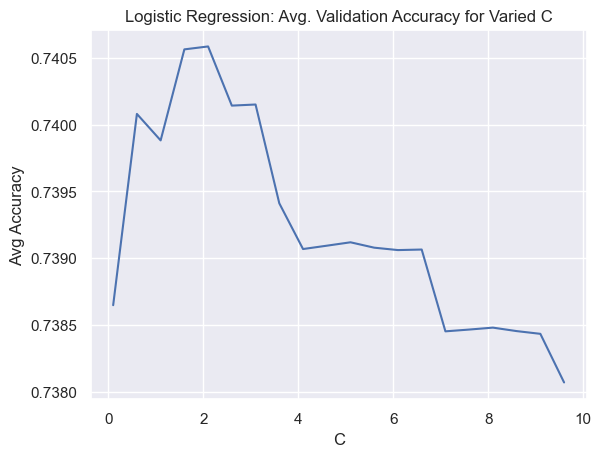

In [113]:
sns.lineplot(accuracy_df, x='C', y='Avg Accuracy')
plt.title('Logistic Regression: Avg. Validation Accuracy for Varied C')

In [66]:
accuracy_df.to_csv('logreg_l2_C_cv.csv')

In [118]:
best_param = accuracy_df['Param Pair'][0]
best_param

(0.01, 'l2')

In [119]:
X_train=X_train.select_dtypes('number')
ros = RandomOverSampler(random_state=0, sampling_strategy = 'minority')
X_train_use, y_train_use = ros.fit_resample(
                    X_train, y_train) 
X_val = X_val.select_dtypes('number')

In [120]:
xg_model = LogisticRegression(max_iter= 200, C=best_param[0], penalty='l2', solver='newton-cholesky')
xg_model.fit(X_train_use.drop(columns=['ID', 'pre_nucleus_id', 'post_nucleus_id']).sort_index(axis=1), y_train_use)

preds = xg_model.predict(X_val.drop(columns=['ID', 'pre_nucleus_id', 'post_nucleus_id']).sort_index(axis=1))
balanced_accuracy_score(y_val, preds)

0.7468604533619534

In [121]:
best_features = pd.DataFrame({"Features":X_train_use.drop(columns=['ID', 'pre_nucleus_id', 'post_nucleus_id']).columns, 
              "Importances":abs(xg_model.coef_[0])}).sort_values(by='Importances', ascending=False)
best_features

,Features,Importances
6,adp_dist,1.481093
21,post_nucleus_y,0.764467
11,pre_rf_x,0.547248
14,post_test_score,0.458340
19,pre_nucleus_z,0.454068
26,RL_pre,0.442104
13,post_oracle,0.419998
20,post_nucleus_x,0.408934
16,post_rf_y,0.223883
34,area3,0.221601


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 1.0, 'Logistic Regression Feature Importance')

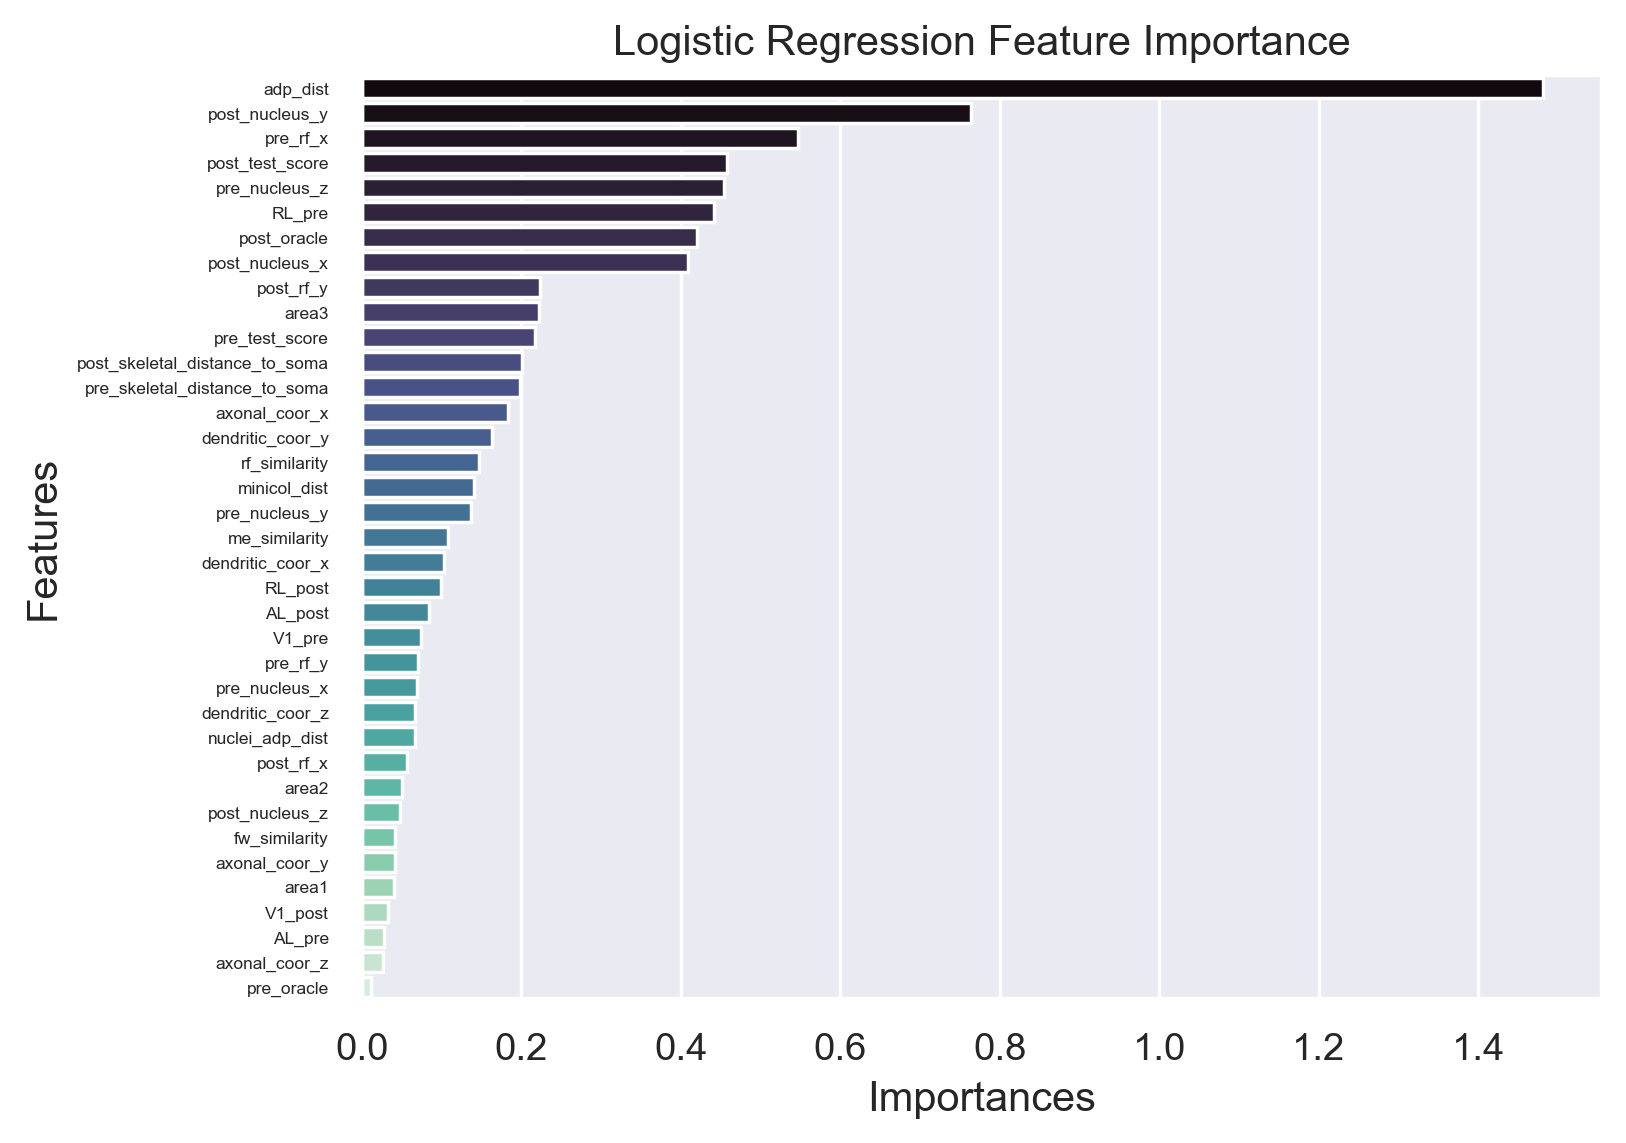

In [122]:
sns.set_theme(palette='deep')
plt.figure(dpi=250)
g = sns.barplot(best_features, y='Features', x='Importances', palette='mako')
g.set_yticklabels(g.get_yticklabels(), fontsize=5)
plt.title("Logistic Regression Feature Importance")
# g.set_xticklabels(g.get_xticklabels(), rotation=90, fontsize=8)


In [71]:
leaderboard_path = "../Data/leaderboard_data.csv"
sub_data = cleaner(leaderboard_path, feature_path, morph_path, submission = True)

In [72]:
sub_data = sub_data.select_dtypes('number')
sub_data.columns

Index(['ID', 'axonal_coor_x', 'axonal_coor_y', 'axonal_coor_z',
       'dendritic_coor_x', 'dendritic_coor_y', 'dendritic_coor_z', 'adp_dist',
       'post_skeletal_distance_to_soma', 'pre_skeletal_distance_to_soma',
       'pre_oracle', 'pre_test_score', 'pre_rf_x', 'pre_rf_y', 'post_oracle',
       'post_test_score', 'post_rf_x', 'post_rf_y', 'pre_nucleus_x',
       'pre_nucleus_y', 'pre_nucleus_z', 'post_nucleus_x', 'post_nucleus_y',
       'post_nucleus_z', 'pre_nucleus_id', 'post_nucleus_id', 'me_similarity',
       'fw_similarity', 'rf_similarity', 'AL_pre', 'RL_pre', 'V1_pre',
       'V1_post', 'RL_post', 'AL_post', 'area1', 'area2', 'area3',
       'minicol_dist', 'nuclei_adp_dist'],
      dtype='object')

In [73]:
preds = xg_model.predict(sub_data.drop(columns=['ID', 'pre_nucleus_id', 'post_nucleus_id']).sort_index(axis=1))


In [74]:
sub_data['connected'] = preds==1

In [123]:
submission_data = sub_data.filter(['ID','connected'])
submission_data.to_csv('submission_data_logreg.csv',index=False)